# Energy Consumption Imputation (ELECTRICITY)

In this notebook, <br>
<b>1)</b> we developed machine learning models based on matched PUMS data (el_training.csv created from the R script) The model training results are saved in el_training_model_comparisons.csv file. <br>
<b>2)</b> We applied the best model to unmatched records (el_imputing.csv created from the R script). The imputed results are saved in el_imputed.csv<br>

## Import python packages

In [58]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression,ElasticNet,Lasso
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, median_absolute_error
from sklearn.utils import check_array
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.cross_validation import KFold, LeaveOneOut, ShuffleSplit,train_test_split
from sklearn.base import clone
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
import csv
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import pandas as pd
import time
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

## Input files identification

In [6]:
energy_source = "el" # energy source "el" - electricity; "ng" - natural gas; "o" - other

energy = "BTU" + energy_source.upper()
fn = "output/" + energy_source + "_training.csv"
test_fn= "output/" + energy_source + "_imputing.csv"

imputed_output_fn = "output/" + energy_source +"_imputed.csv"
out_fn = "output/" + energy_source + "_training_model_comparisons.csv"

## Data processing

In [88]:
print "DATA PREPORCESSING"
print "-"*70
original_mateched = pd.read_csv(fn)
X = pd.read_csv(fn)
# exclude columns that are irrelevant to energy consumption
exclude_names = ["SERIALNO", "RT", "DIVISION","PUMA","REGION","ST","ADJHSG","ADJINC","WGTP"] 
X.drop(exclude_names, inplace= True, axis = 1)
column_names = list(X)

f_cat_count = 0
f_con_count = 0
percentNAN = []
print "Index\tName\t%15s\t%15s"%("Mean", "Std. Dev.")
for i,name in enumerate(column_names):
    
    if name[-1] != "P" and name != energy:
        X[name] = X[name].astype('category') # variables with names not ending with "P" are categorical
        f_cat_count += 1 
        missingVals = pd.isnull(X[name])
        percentNAN.append([name,sum(missingVals)/float(X.shape[0])])

    elif name != energy:
        missingVals = pd.isnull(X[name])
        percentNAN.append([name,sum(missingVals)/float(X.shape[0])])
        col_mean = X[name].mean()
        col_std = X[name].std()
        X[name] = X[name].astype('float')
        f_con_count += 1
        print "%i\t%s\t%15.2f\t%15.2f"%(f_con_count, name, col_mean, col_std)
    elif name == energy:
        X[name] = X[name].astype('float')


droppedFeatures = []
for i, item in enumerate(percentNAN):
    name = item[0]
    percentMissing = item[1]
    if percentMissing > 0.1: # drop varialbes that has more than 10% missing values
        if name[-1] == "P":
            f_con_count -= 1
        else:
            f_cat_count -= 1
        X = X.drop(name,1)
        droppedFeatures.append(name)


X = pd.get_dummies(X) # convert categorical variables into dummies


Y = X[energy]
X = X.drop(energy,1)
observation, features = X.shape
print "-"*70
print "number of observation: %d \nnumber of features: %d \nnumber of continuous variables: %d\nnumber of categorical variables: %d\nnumber of features dropped due to missing values: %d" % (observation, features, f_con_count, f_cat_count, len(droppedFeatures))
print "-"*70
print "Dropped Features"
print "-"*70
print droppedFeatures

DATA PREPORCESSING
----------------------------------------------------------------------
Index	Name	           Mean	      Std. Dev.
1	NP	           2.41	           1.36
2	BDSP	           2.89	           1.06
3	CONP	         192.21	         136.38
4	ELEP	         143.85	          76.65
5	FULP	          46.51	         250.53
6	GASP	          55.65	          77.25
7	INSP	         689.72	         583.79
8	MHP	         451.85	        1025.61
9	MRGP	        1098.04	         705.55
10	RMSP	           6.11	           2.12
11	RNTP	         645.51	         319.74
12	SMP	         371.74	         388.07
13	VALP	      199156.18	      188921.12
14	WATP	         328.04	         356.58
15	FINCP	       73093.92	       71091.63
16	GRNTP	         814.49	         349.62
17	GRPIP	          41.94	          28.44
18	HINCP	       62820.05	       64993.95
19	NPP	           0.01	           0.11
20	OCPIP	          25.24	          20.79
21	SMOCP	        1185.69	         948.26
22	TAXP	          25.33	          1

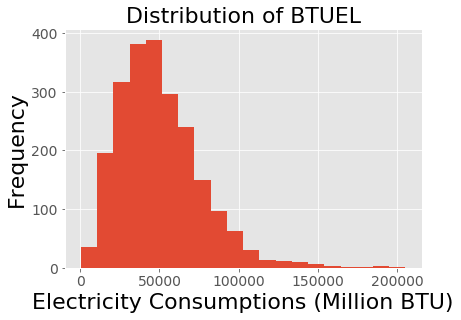

In [38]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(Y, 20)

ax.set_title("Distribution of BTUEL", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("Electricity Consumptions (Million BTU)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

## Regressor and metrics set up 

In [40]:
# Average percent difference
def averagePercentDifference(predictions, actual): 
    assert len(predictions) == len(actual)
    return np.mean(np.abs(predictions - actual)/actual) * 100

regressors = [
    Ridge(),
    LinearRegression(),
    ElasticNet(),
    Lasso(),
    AdaBoostRegressor(),
    BaggingRegressor(),
    GradientBoostingRegressor(max_depth=4, n_estimators=20, verbose=1),
    RandomForestRegressor(max_depth=3, n_estimators= 60, n_jobs=-1, verbose=0),
    ExtraTreesRegressor(max_depth=3, n_jobs=-1, verbose=0),
    MLPRegressor()
]

regressorNames = [
    "Ridge Regressor",
    "Linear Regressor",
    "ElasticNet",
    "Lasso",
    "AdaBoost Regressor",
    "Bagging Regressor",
    "Gradient Boosting Regressor, 4_20",
    "Random Forest Regressor",
    "Extra Trees Regressor",
    "MLPRegressor"
]

assert len(regressors) == len(regressorNames)

metrics = [
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    averagePercentDifference
]

metricNames = [
    "Mean Absolute Error",
    "Median Absolute Error",
    "$r^2$",
    "Mean Average Percent Difference"
]

assert len(metrics) == len(metricNames)

## Run experiements

In [63]:
print "RUNNING EXPERIMENTS"
print "-"*70

numberOfExperiments = 10
numberOfSamples = X.shape[0]
startTime = float(time.time())

bestMetric = metrics[0] # metric which we use to save the best regressor 
bestMetricScores = [float('inf') for _ in range(len(regressors))]
bestRegressorModels = [None for _ in range(len(regressors))]
bestRegressorNames = regressorNames
bestMetricScoresList = [[] for _ in range(len(regressors))]

results = [] # [k][i][j] is the results on the the jth metric for the ith regressor in the kth experiment run

crossValidatorIterator = ShuffleSplit(n=numberOfSamples, n_iter=numberOfExperiments, test_size=0.25, train_size=None, random_state=None)

for i, (train_index, test_index) in enumerate(crossValidatorIterator):
    print "Running experiment %d out of %d" % (i+1, numberOfExperiments)
    
    regressorScores = [] # [i][j] is the jth metric result for the ith regressor
    X_train, X_test = X.loc[train_index,], X.loc[test_index,]
    y_train, y_test = Y.loc[train_index,], Y.loc[test_index,]

    for j, (regressor,regressorName) in enumerate(zip(regressors,regressorNames)):
        print "\tTraining %s" % (regressorName)
        regressor = clone(regressor)
        
        regressor.fit(X_train,y_train)
        predicted = regressor.predict(X_test)
        predicted[predicted<0] = 0 # if prediction smaller than 0 convert to 0
        
        scores = []
        for metric in metrics:
            score = metric(y_test,predicted)
            scores.append(score)
        
        #Record best trained model
        score = bestMetric(y_test,predicted)
        if score < bestMetricScores[j]:
            bestMetricScores[j] = score
            bestRegressorModels[j] = regressor
            bestMetricScoresList[j] = scores
            
        regressorScores.append(scores)
                
    results.append(regressorScores)

results = np.array(results)

RUNNING EXPERIMENTS
----------------------------------------------------------------------
Running experiment 1 out of 10
	Training Ridge Regressor
	Training Linear Regressor
	Training ElasticNet
	Training Lasso
	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   555306928.8833            0.22s
         2   465798735.8731            0.21s
         3   393133552.9130            0.20s
         4   334168661.6369            0.18s
         5   286284618.8545            0.17s
         6   246961623.9935            0.16s
         7   215222189.0858            0.15s
         8   189041722.4667            0.14s
         9   167804462.0800            0.13s
        10   150355788.9936            0.12s
        20    79404001.6871            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 2 out of 10
	Training Ridge Regressor


In [94]:
def processResults(results, regressorNames, metricNames, y=None):
    #results is a 3 dimensional array where results[k][i][j] is the result for the jth metric on the ith regressor in the kth experiment run
    
    #take the average and standard deviations over all the experimental runs
    means = results.mean(axis=0)
    stds  = results.std(axis=0)

    print("Sanity Check")
    print("------------------------")
    print("Results shape: %s" % (str(results.shape)))
    print("Shape of means: %s" % (str(means.shape)))
    print("Shape of stds : %s" % (str(stds.shape)))
    print("")
    print("Creating the result DataFrames")
    print("------------------------")
    df_means = pd.DataFrame(means, index=regressorNames, columns=metricNames)
    df_stds  = pd.DataFrame(stds , index=regressorNames, columns=metricNames)

    # combine table values into single table with STD represented as +/-
    combined_df_data = []
    for metricName in metricNames:
        tempData = []
        for regressorName in regressorNames:
            
            tempString = ""
            
            if abs(df_means[metricName][regressorName]) > 1000:
                tempString += "%0.2e" % (df_means[metricName][regressorName])
            else:
                tempString += "%0.2f" % (df_means[metricName][regressorName])
            
            tempString += " +/- "
            
            if abs(df_stds[metricName][regressorName]) > 1000:
                tempString += "%0.2e" % (df_stds[metricName][regressorName])
            else:
                tempString += "%0.2f" % (df_stds[metricName][regressorName])
            
            tempData.append(tempString)
        combined_df_data.append(tempData)

    combined_df_data = np.array(combined_df_data)
    combinedDf = pd.DataFrame(combined_df_data.T, index=regressorNames, columns=metricNames)
    return combinedDf

processedResults = processResults(results, regressorNames, metricNames)
print processedResults
processedResults.to_csv(out_fn, sep = ",")

Sanity Check
------------------------
Results shape: (10, 10, 4)
Shape of means: (10, 4)
Shape of stds : (10, 4)

Creating the result DataFrames
------------------------
                                     Mean Absolute Error  \
Ridge Regressor                      6.68e+03 +/- 367.07   
Linear Regressor                     6.72e+03 +/- 382.98   
ElasticNet                           6.43e+03 +/- 345.03   
Lasso                                6.70e+03 +/- 378.36   
AdaBoost Regressor                   8.50e+03 +/- 373.63   
Bagging Regressor                    7.10e+03 +/- 332.87   
Gradient Boosting Regressor, 4_20    7.02e+03 +/- 336.89   
Random Forest Regressor              6.93e+03 +/- 344.67   
Extra Trees Regressor                8.74e+03 +/- 820.38   
MLPRegressor                       1.97e+04 +/- 2.35e+03   

                                   Median Absolute Error           $r^2$  \
Ridge Regressor                      4.65e+03 +/- 231.14   0.87 +/- 0.01   
Linear Regressor 

## Model Errors Visualization (Model applied to the entire training dataset)

Training model 1/10	Ridge Regressor


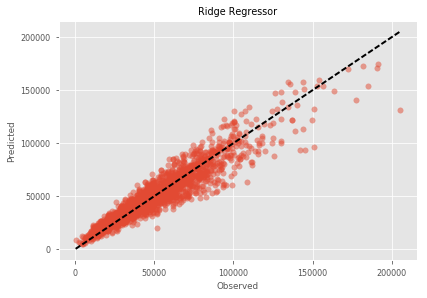

Training model 2/10	Linear Regressor


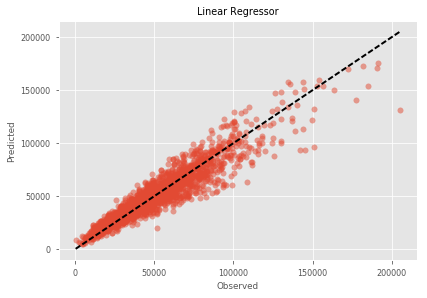

Training model 3/10	ElasticNet


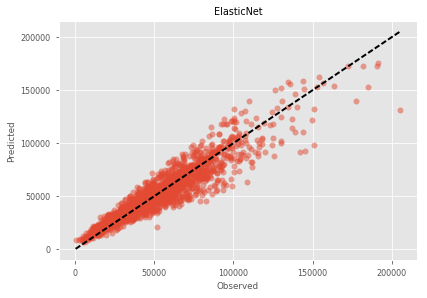

Training model 4/10	Lasso


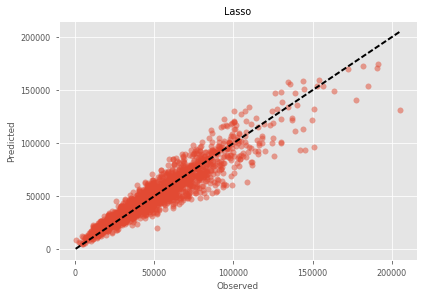

Training model 5/10	AdaBoost Regressor


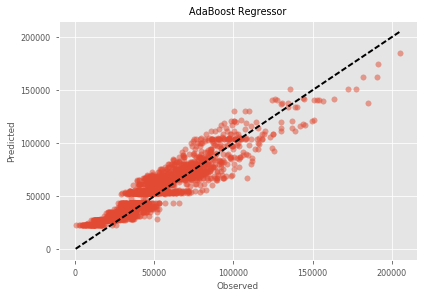

Training model 6/10	Bagging Regressor


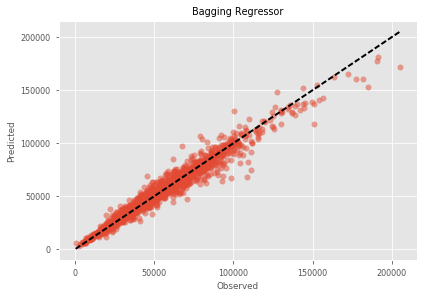

Training model 7/10	Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   570314937.4401            0.26s
         2   477999182.2481            0.24s
         3   402760715.7225            0.24s
         4   341760716.2234            0.22s
         5   292413449.6324            0.21s
         6   251945336.0493            0.20s
         7   219158170.3644            0.18s
         8   192499614.6246            0.16s
         9   170667112.8389            0.15s
        10   152856892.4320            0.14s
        20    80933940.8612            0.00s


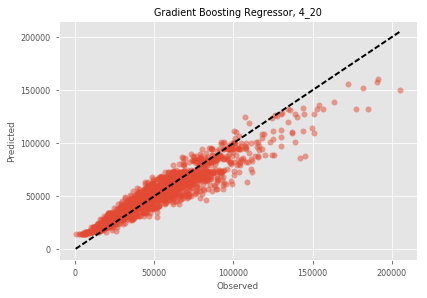

Training model 8/10	Random Forest Regressor


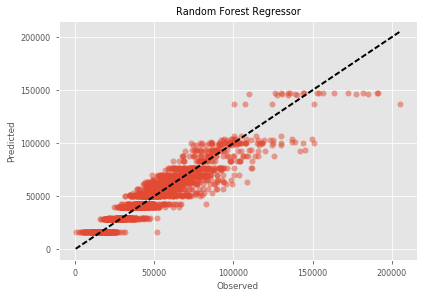

Training model 9/10	Extra Trees Regressor


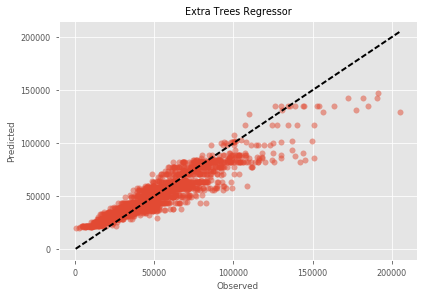

Training model 10/10	MLPRegressor


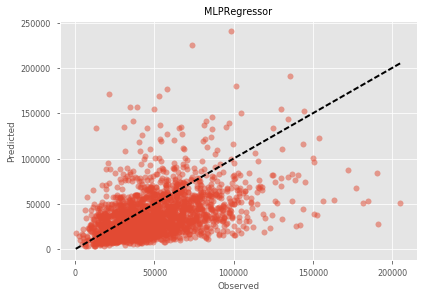

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

for i in range(len(regressors)):
    regressor = clone(regressors[i])
    regressorName = regressorNames[i]
    
    print "Training model %d/%d\t%s" % (i+1, len(regressors), regressorName)
    
    regressor.fit(X_train,Y_train)
    
    #predict model
    predicted = regressor.predict(X_test)
    predicted[predicted<0] = 0

    #evaluate model
    scores = []
    for l,metric in enumerate(metrics):
        metricName = metricNames[l]
        score = metric(Y_test,predicted)
        scores.append((metricName,score))
    
    predicted = regressor.predict(X)
    plt.figure(1)
    plt.subplot()
    plt.title(regressorName)
    plt.scatter(Y, predicted, alpha = 0.5)
    plt.plot([min(Y), max(Y)], [min(Y), max(Y)], 'k--', lw=2)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    plt.close()


## Feature importances

In [72]:
bestIndex = bestMetricScores.index(min(bestMetricScores))
bestModel = bestRegressorModels[bestIndex]
bestModelName = regressorNames[bestIndex]
print "-"*70
print "The best model is %s \n"% bestModelName

featureNames = list(X)
featureImportances = bestModel.coef_
featureRanking = {i:featureImportance for i,featureImportance in enumerate(bestModel.coef_)}
sortedFeatures = sorted(featureRanking, key=featureRanking.get, reverse=True)

print "-"*70
print "The top 10 features are "
print "-"*70
print "Name\tIndex\tRanking"
topFeatures = []
for featureIndex in sortedFeatures[:10]:
    topFeatures.append(featureImportances[featureIndex])
    print "%s\t%i\t%5.2f"%(featureNames[featureIndex], featureIndex, featureRanking[featureIndex])

----------------------------------------------------------------------
The best model is ElasticNet 

----------------------------------------------------------------------
The top 10 features are 
----------------------------------------------------------------------
Name	Index	Ranking
RMSP	5	644.12
BLD_2	13	396.33
YBL_7	59	334.58
ELEP	2	307.74
BDSP	1	261.29
NP	0	221.91
HFL_2	24	191.54
HHT_1	71	189.73
VEH_3	49	189.67
PSF_1	128	185.76


## Impute unmatched records

In [93]:
unmatched = pd.read_csv(test_fn)
original_unmatched = pd.read_csv(test_fn)

for i,name in enumerate(column_names):
    if name[-1] != "P" and name != energy:
        unmatched[name] = unmatched[name].astype('category')
    elif name != energy:
        col_mean = unmatched[name].mean()
        col_std = unmatched[name].std()
        unmatched[name] = unmatched[name].astype('float')
#         print name, col_mean, col_std


for featureName in droppedFeatures:
    unmatched = unmatched.drop(featureName,1)

unmatched = pd.get_dummies(unmatched)
newfeatureNames = list(unmatched)

for newfeatureName in newfeatureNames:
    if newfeatureName not in list(X):
        unmatched = unmatched.drop(newfeatureName, 1)

observation, features = unmatched.shape

bestModel.fit(X,Y)
imputed_values = bestModel.predict(unmatched)
imputed_values[imputed_values<0,]=0
original_unmatched[energy]=imputed_values

print "matched y mean: %0.2f, std: %0.2f" %(Y.mean(),Y.std())
print "imputed y mean: %0.2f, std: %0.2f" %(imputed_values.mean(),imputed_values.std())
final_output = pd.concat([original_unmatched, original_mateched])
final_output.to_csv(imputed_output_fn, header = True, index = False)

matched y mean: 50276.80, std: 26295.70
imputed y mean: 52371.86, std: 28860.60
